Loaded 400000 word vectors!

=== Trial 1/10 ===
Started from 'cabals' — converged closest to: 'cabals'
Started from 'nikulin' — converged closest to: 'nikulin'
Started from 'gowanus' — converged closest to: 'gowanus'
Started from 'septima' — converged closest to: 'septima'
Started from 'wfm' — converged closest to: 'wfm'
Started from '18.76' — converged closest to: '18.76'
Started from 'balboni' — converged closest to: 'balboni'
Started from 'tomiyama' — converged closest to: 'tomiyama'
Started from '433,000' — converged closest to: '433,000'
Started from 'memoriam' — converged closest to: 'memoriam'
Started from 'inundation' — converged closest to: 'inundation'
Started from 'mulele' — converged closest to: 'mulele'
Started from 'grotta' — converged closest to: 'grotta'
Started from '85.40' — converged closest to: '85.40'
Started from 'thermography' — converged closest to: 'thermography'
Started from 'bramhall' — converged closest to: 'bramhall'
Started from 'www.nytrng.com' — converge

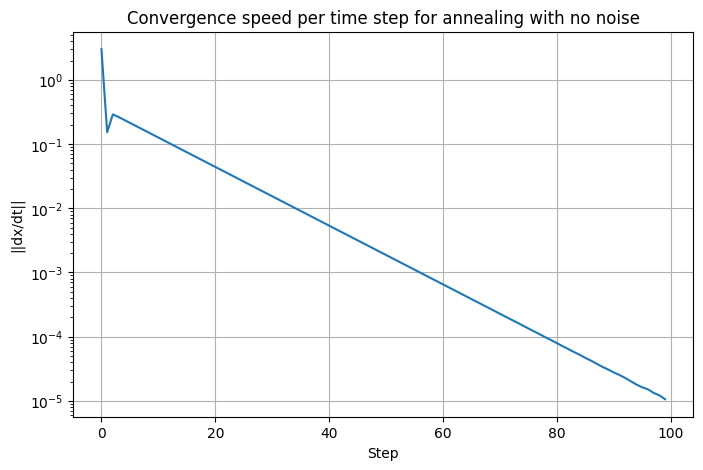

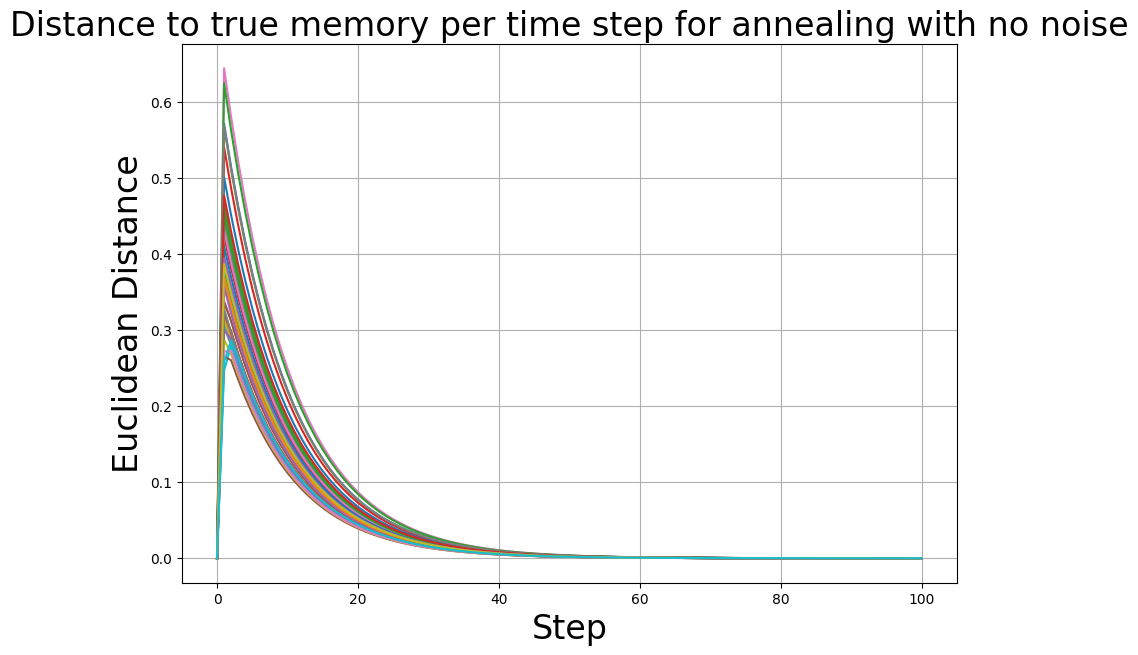

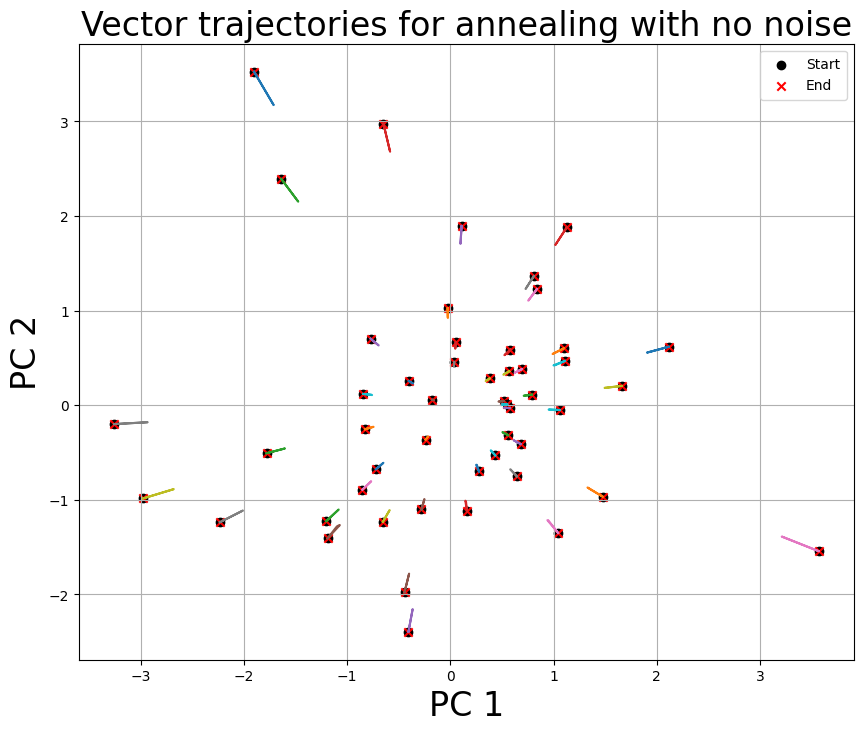

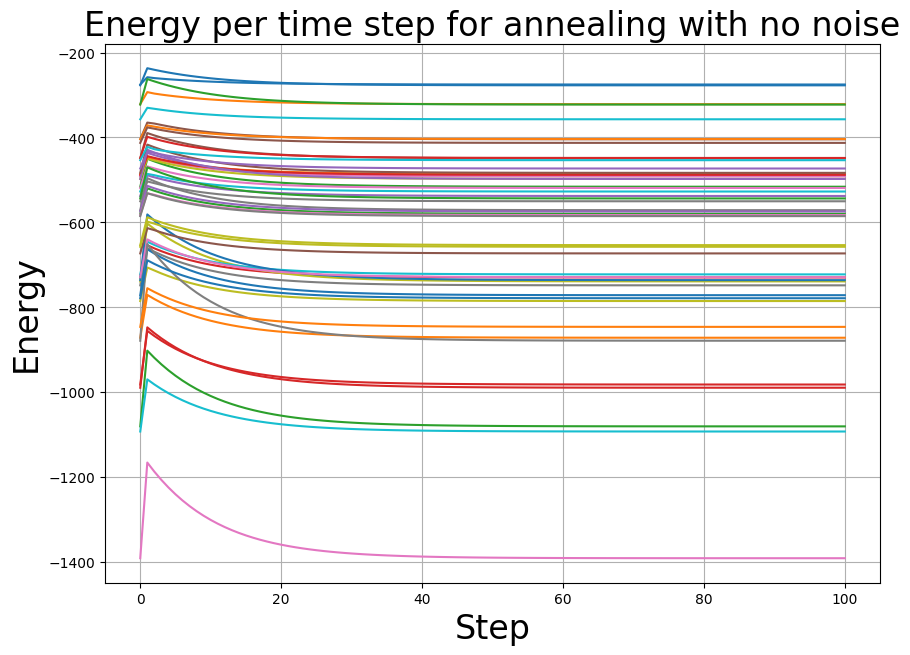


=== Trial 2/10 ===
Trial 2: Success rate = 100.0%

=== Trial 3/10 ===
Trial 3: Success rate = 98.0%

=== Trial 4/10 ===
Trial 4: Success rate = 90.0%

=== Trial 5/10 ===
Trial 5: Success rate = 100.0%

=== Trial 6/10 ===
Trial 6: Success rate = 98.0%

=== Trial 7/10 ===
Trial 7: Success rate = 98.0%

=== Trial 8/10 ===
Trial 8: Success rate = 98.0%

=== Trial 9/10 ===
Trial 9: Success rate = 96.0%

=== Trial 10/10 ===
Trial 10: Success rate = 100.0%

=== Overall Results ===
Average Success Rate over 10 trials: 97.8%
Standard Deviation: 2.9%


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

# === Load dataset ===
glove_path = 'C:\\Users\\hhl222\\Downloads\\glove.6B.50d.txt'
word_vectors = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        word_vectors[word] = vector
print(f"Loaded {len(word_vectors)} word vectors!")

# === Softmax function ===
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

# === Energy function ===
def compute_energy(x, Xi):
    # Energy: E = - (1/2) * x^T Xi^T Xi x
    # Xi^T Xi is like the weight matrix in this modern hopfield setup
    W = Xi.T @ Xi
    return -0.5 * x.T @ W @ x

# === Annealing Modern Hopfield Network evolution ===
def anneal_hopfield(Xi, initial_x, steps=100, beta_max=100, dt=0.1):
    N = Xi.shape[1]
    K = Xi.shape[0]

    w = np.zeros(K)
    x = initial_x.copy()
    trajectory = [x.copy()]
    energies = [compute_energy(x, Xi)]

    for t in range(steps):
        beta = beta_max * (t / steps)
        logits = beta * (Xi @ x) + beta * w
        p = softmax(logits)

        x_dot = Xi.T @ p - x
        x += dt * x_dot

        trajectory.append(x.copy())
        energies.append(compute_energy(x, Xi))

    return np.array(trajectory), np.array(energies)

# === Find closest word ===
def find_closest(x, Xi, word_list):
    sims = (Xi @ x) / (np.linalg.norm(Xi, axis=1) * np.linalg.norm(x) + 1e-8)
    idx = np.argmax(sims)
    return word_list[idx]

# === Run annealing for all stored words ===
def run_annealing_all_words(Xi, subset_words, steps=100, beta_max=100, dt=0.1, verbose=False):
    K, N = Xi.shape

    trajectories = []
    final_words = []
    success_count = 0
    all_distances = np.zeros((K, steps+1))
    all_energies = []

    for i in range(K):
        initial_x = Xi[i]
        traj, energies = anneal_hopfield(Xi, initial_x, steps=steps, beta_max=beta_max, dt=dt)
        trajectories.append(traj)
        all_energies.append(energies)

        for t in range(steps+1):
            all_distances[i, t] = np.linalg.norm(traj[t] - Xi[i])

        final_x = traj[-1]
        closest_word = find_closest(final_x, Xi, subset_words)
        final_words.append(closest_word)

        if closest_word == subset_words[i]:
            success_count += 1

        if verbose:
            print(f"Started from '{subset_words[i]}' — converged closest to: '{closest_word}'")

    success_rate = success_count / K

    if verbose:
        print(f"Success rate: {success_rate*100:.1f}%")

    return np.array(trajectories), final_words, success_rate, all_distances, np.array(all_energies)

# === Plotting functions ===
def plot_convergence_norm(trajectory, dt=0.1):
    dx_norms = [np.linalg.norm(trajectory[i+1] - trajectory[i]) / dt for i in range(len(trajectory)-1)]
    plt.figure(figsize=(8, 5))
    plt.plot(dx_norms)
    plt.yscale('log')
    plt.xlabel('Step')
    plt.ylabel('||dx/dt||')
    plt.title('Convergence speed per time step for annealing with no noise')
    plt.grid(True)
    plt.show()

def plot_euclidean_distances(all_distances, subset_words):
    plt.figure(figsize=(10, 7))
    time = np.arange(all_distances.shape[1])

    for i in range(all_distances.shape[0]):
        plt.plot(time, all_distances[i])  # no label, no legend

    plt.xlabel("Step", fontsize=24)
    plt.ylabel("Euclidean Distance", fontsize=24)
    plt.title("Distance to true memory per time step for annealing with no noise", fontsize=24)
    plt.grid(True)
    plt.show()

def plot_trajectories_pca(trajectories, subset_words):
    # Stack all trajectories together for global PCA
    all_points = np.vstack(trajectories)
    pca = PCA(n_components=2)
    pca.fit(all_points)
    
    plt.figure(figsize=(10, 8))
    for idx, traj in enumerate(trajectories):
        traj_2d = pca.transform(traj)
        plt.plot(traj_2d[:, 0], traj_2d[:, 1])
        
        # Start point (black dot)
        plt.scatter(traj_2d[0, 0], traj_2d[0, 1], marker='o', c='black')
        
        # End point (red cross)
        plt.scatter(traj_2d[-1, 0], traj_2d[-1, 1], marker='x', c='red')

    # Add a legend manually
    plt.scatter([], [], marker='o', c='black', label='Start')
    plt.scatter([], [], marker='x', c='red', label='End')
    
    memories_2d = pca.transform(Xi)

    plt.legend(loc='upper right', fontsize=10, frameon=True, borderpad=0.5)

    plt.xlabel("PC 1", fontsize=24)
    plt.ylabel("PC 2", fontsize=24)
    plt.title("Vector trajectories for annealing with no noise", fontsize=24)
    plt.grid(True)
    plt.show()

def plot_energy(all_energies):
    plt.figure(figsize=(10, 7))
    time = np.arange(all_energies.shape[1])
    for i in range(all_energies.shape[0]):
        plt.plot(time, all_energies[i])
    plt.xlabel("Step", fontsize=24)
    plt.ylabel("Energy", fontsize=24)
    plt.title("Energy per time step for annealing with no noise", fontsize=24)
    plt.grid(True)
    plt.show()

# === MAIN EXPERIMENT LOOP ===
NUM_TRIALS = 10
SUCCESS_RATES = []

for trial in range(NUM_TRIALS):
    print(f"\n=== Trial {trial+1}/{NUM_TRIALS} ===")

    # Sample 50 words randomly
    all_words = list(word_vectors.keys())
    subset_words = random.sample(all_words, 50)
    Xi = np.stack([word_vectors[word] for word in subset_words])

    # Run annealing
    trajectories, final_words, success_rate, all_distances, all_energies = run_annealing_all_words(
        Xi, subset_words, steps=100, beta_max=100, dt=0.1, verbose=(trial==0)
    )
    SUCCESS_RATES.append(success_rate)
    print(f"Trial {trial+1}: Success rate = {success_rate*100:.1f}%")

    # Plot graphs for the FIRST trial only
    if trial == 0:
        # Plot convergence speed (first word)
        plot_convergence_norm(trajectories[0], dt=0.1)

        # Plot Euclidean distances for first 5 words
        plot_euclidean_distances(all_distances, subset_words)

        # Plot trajectories in PCA space
        plot_trajectories_pca(trajectories, subset_words)

        # Plot energy over time
        plot_energy(all_energies)

# === Summary statistics ===
mean_success = np.mean(SUCCESS_RATES)
std_success = np.std(SUCCESS_RATES)
print("\n=== Overall Results ===")
print(f"Average Success Rate over {NUM_TRIALS} trials: {mean_success*100:.1f}%")
print(f"Standard Deviation: {std_success*100:.1f}%")
